In [1]:
import os
os.chdir('/mnt/jw01-aruk-home01/projects/ra_challenge/RA_challenge/RA2_alpine_lads/ra_joint_predictions')

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from utils.config import Config
import re
import random
import PIL
from dataset.ops import image_ops, joint_ops, dataset_ops
configuration = Config()

In [3]:

hand_joint_keys = ['mcp', 'pip_2', 'pip_3', 'pip_4', 'pip_5', 'mcp_1', 'mcp_2', 'mcp_3', 'mcp_4', 'mcp_5']

hand_wrist_keys = ['w1', 'w2', 'w3']

feet_joints_keys = ["mtp", "mtp_1", "mtp_2", "mtp_3", "mtp_4", "mtp_5"]

class overall_test_hand():
    def __init__(self, config, img_dir, is_regression = True ,pad_resize = False, joint_scale = 5, cache_postfix = '', imagenet = False, is_test = False):
        self.img_dir = img_dir
        self.pad_resize = pad_resize
        self.joint_scale = joint_scale
        self.imagenet = imagenet
        self.cache = config.cache_loc + cache_postfix # there's no cache
        self.joint_height = config.joint_img_height
        self.joint_width = config.joint_img_width
        self.buffer_size = 200 # there's no buffer
        self.is_test = is_test

    def create_generator(self, joints_source = "./data/predictions/hand_joint_data_train_v2.csv", outcomes_source = None, erosion_flag = False):
        def __get_hand_outcome(outcomes_dataframe, erosion_flag = False):
            if erosion_flag:
                s = "E"
            else:
                s = "J"
            per_image_outcome = pd.DataFrame(outcomes_dataframe["Patient_ID"].values)
            what = re.compile(f".*LH.*{s}.*")
            wanted_cols = list(filter(what.match, outcomes_dataframe.columns))
            per_image_outcome["LH"] = outcomes_dataframe[wanted_cols].sum(axis = 1)
            what = re.compile(f".*RH.*{s}.*")
            wanted_cols = list(filter(what.match, outcomes_dataframe.columns))
            per_image_outcome["RH"] = outcomes_dataframe[wanted_cols].sum(axis = 1)
            per_image_outcome = per_image_outcome.melt(id_vars=0)
            per_image_outcome["image"] = per_image_outcome[0].astype(str) + "-" + per_image_outcome["variable"].astype(str)
            return per_image_outcome[["image","value"]]
        
        joints_dataframe = pd.read_csv(joints_source,index_col=0).set_index("image_name")
        
        if self.is_test :
            return self._image_generator(joints_dataframe, is_test = True)
        else:
            outcomes_dataframe = __get_hand_outcome(pd.read_csv(outcomes_source),erosion_flag).set_index("image")
            return self._image_generator(joints_dataframe, outcomes = outcomes_dataframe)

    def _image_generator(self, joints_dataframe, is_test = False, outcomes = None):
        while True:
            images = joints_dataframe.index.to_list()
            random.shuffle(images) 
            selected_images = random.sample(images, 10)
            batch = []
            for image in images:
                full_image = image_ops.load_image([image,joints_dataframe.loc[image,"file_type"],joints_dataframe.loc[image,"flip"]], None, 
                                                 self.img_dir, imagenet = self.imagenet)[0]
                
                list_of_joints = _get_hand_joints(full_image,joints_dataframe.loc[image,:], joint_scale = self.joint_scale)
                
                for joint_img in range(len(list_of_joints)):
                    list_of_joints[joint_img] = dataset_ops._augment_and_clip_image(list_of_joints[joint_img], None,)[0]
                    list_of_joints[joint_img] = image_ops.resize_image(list_of_joints[joint_img], None, self.joint_height, self.joint_width,
                                                                      pad_resize = self.pad_resize)[0]
                    if self.imagenet:
                        list_of_joints[joint_img] = image_ops.get_3_channels(list_of_joints[joint_img], None)[0]
                    
                    list_of_joints[joint_img] = list_of_joints[joint_img].numpy()
                    
                batch.append(list_of_joints)

            batch = list(map(list, zip(*batch)))
            if is_test:
                yield batch, selected_images
            else:
                yield batch, outcomes.loc[selected_images,"value"].values


class overall_test_feet():
    def __init__(self, config, img_dir, is_regression = True ,pad_resize = False, joint_scale = 5, cache_postfix = '', imagenet = False, is_test = False):
        self.img_dir = img_dir
        self.pad_resize = pad_resize
        self.joint_scale = joint_scale
        self.imagenet = imagenet
        self.cache = config.cache_loc + cache_postfix # there's no cache
        self.joint_height = config.joint_img_height
        self.joint_width = config.joint_img_width
        self.buffer_size = 200 # there's no buffer
        self.is_test = is_test

    def create_generator(self, joints_source = "./data/predictions/feet_joint_data_train_v2.csv", outcomes_source = None, erosion_flag = False):
        def __get_feet_outcome(outcomes_dataframe, erosion_flag = False):
            if erosion_flag:
                s = "E"
            else:
                s = "J"
            per_image_outcome = pd.DataFrame(outcomes_dataframe["Patient_ID"].values)
            what = re.compile(f".*LF.*{s}.*")
            wanted_cols = list(filter(what.match, outcomes_dataframe.columns))
            per_image_outcome["LF"] = outcomes_dataframe[wanted_cols].sum(axis = 1)
            what = re.compile(f".*RF.*{s}.*")
            wanted_cols = list(filter(what.match, outcomes_dataframe.columns))
            per_image_outcome["RF"] = outcomes_dataframe[wanted_cols].sum(axis = 1)
            per_image_outcome = per_image_outcome.melt(id_vars=0)
            per_image_outcome["image"] = per_image_outcome[0].astype(str) + "-" + per_image_outcome["variable"].astype(str)
            return per_image_outcome[["image","value"]]
        
        joints_dataframe = pd.read_csv(joints_source,index_col=0).set_index("image_name")
        
        if self.is_test :
            return self._image_generator(joints_dataframe, is_test = True)
        else:
            outcomes_dataframe = __get_feet_outcome(pd.read_csv(outcomes_source),erosion_flag).set_index("image")
            return self._image_generator(joints_dataframe, outcomes = outcomes_dataframe)

    def _image_generator(self, joints_dataframe, is_test = False, outcomes = None):
        while True:
            images = joints_dataframe.index.to_list()
            random.shuffle(images) 
            selected_images = random.sample(images, 10)
            batch = []
            for image in selected_images:
                full_image = image_ops.load_image([image,joints_dataframe.loc[image,"file_type"],joints_dataframe.loc[image,"flip"]], None, 
                                                 self.img_dir, imagenet = self.imagenet)[0]
                
                list_of_joints = _get_feet_joints(full_image,joints_dataframe.loc[image,:], joint_scale = self.joint_scale)
                
                for joint_img in range(len(list_of_joints)):
                    list_of_joints[joint_img] = dataset_ops._augment_and_clip_image(list_of_joints[joint_img], None,)[0]
                    list_of_joints[joint_img] = image_ops.resize_image(list_of_joints[joint_img], None, self.joint_height, self.joint_width,
                                                                      pad_resize = self.pad_resize)[0]
                    if self.imagenet:
                        list_of_joints[joint_img] = image_ops.get_3_channels(list_of_joints[joint_img], None)[0]
                    
                    list_of_joints[joint_img] = list_of_joints[joint_img].numpy()
                    
                batch.append(list_of_joints)
                
            batch = list(map(list, zip(*batch)))
            if is_test:
                yield batch, selected_images
            else:
                yield batch, outcomes.loc[selected_images,"value"].values


def _get_hand_joints(full_image, coords, joint_scale):
    joints = []
    for key in hand_joint_keys:
        joints.append(joint_ops._extract_joint_from_image(full_image,coords[key + "_x"], coords[key + "_y"], joint_scale))
    joints.append(joint_ops._extract_wrist_from_image(full_image, *coords[["w1_x", "w2_x", "w3_x", "w1_y", "w2_y", "w3_y"]].to_list()))
    return joints

def _get_feet_joints(full_image, coords, joint_scale):
    joints = []
    for key in feet_joints_keys:
        joints.append(joint_ops._extract_joint_from_image(full_image,coords[key + "_x"], coords[key + "_y"], joint_scale))
    return joints

In [17]:
train_dataset_class = overall_test_feet(configuration,"/mnt/jw01-aruk-home01/projects/ra_challenge/RA_challenge/training_dataset/fixed",is_test=True)
a = train_dataset_class.create_generator(outcomes_source = "/mnt/iusers01/jw01/mdefscs4/ra_challenge/RA_challenge/training_dataset/training.csv")

In [241]:
outcomes_dataframe = pd.read_csv("/mnt/iusers01/jw01/mdefscs4/ra_challenge/RA_challenge/training_dataset/training.csv")
joints_dataframe =  pd.read_csv('./data/predictions/feet_joint_data_train_v2.csv',index_col=0)

In [20]:
da = next(a)

2020-03-25 23:28:05,567;WARNING - 11 out of the last 11 calls to <function to_4D_image at 0x7f32582c02f0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/beta/tutorials/eager/tf_function#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.
2020-03-25 23:28:05,601;WARNING - 11 out of the last 11 calls to <function to_4D_image at 0x7f32582c02f0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/beta/tutorials

In [21]:
da[1]

['UAB573-RF',
 'UAB272-RF',
 'UAB560-RF',
 'UAB166-RF',
 'UAB200-RF',
 'UAB054-LF',
 'UAB229-RF',
 'UAB252-RF',
 'UAB277-RF',
 'UAB167-LF']

UAB573-RF
UAB272-RF
UAB560-RF
UAB166-RF
UAB200-RF
UAB054-LF
UAB229-RF
UAB252-RF
UAB277-RF
UAB167-LF


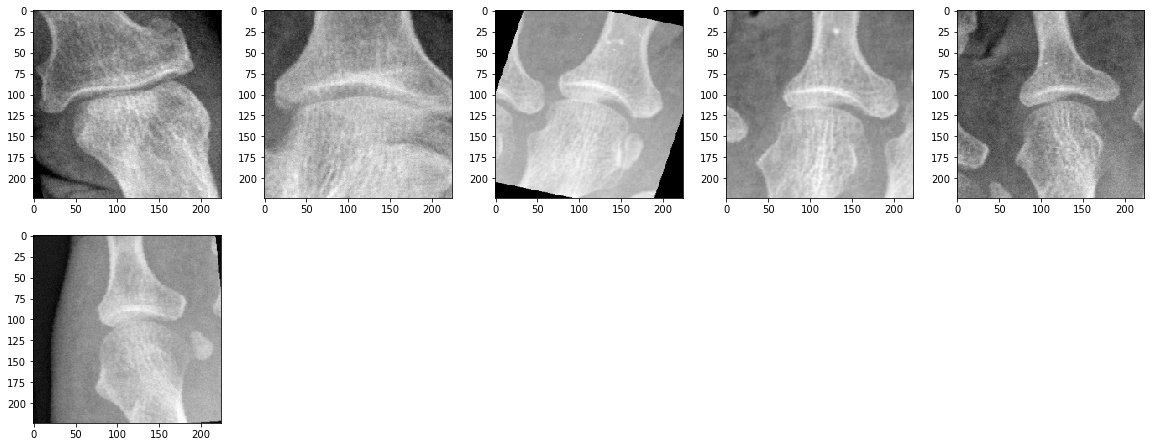

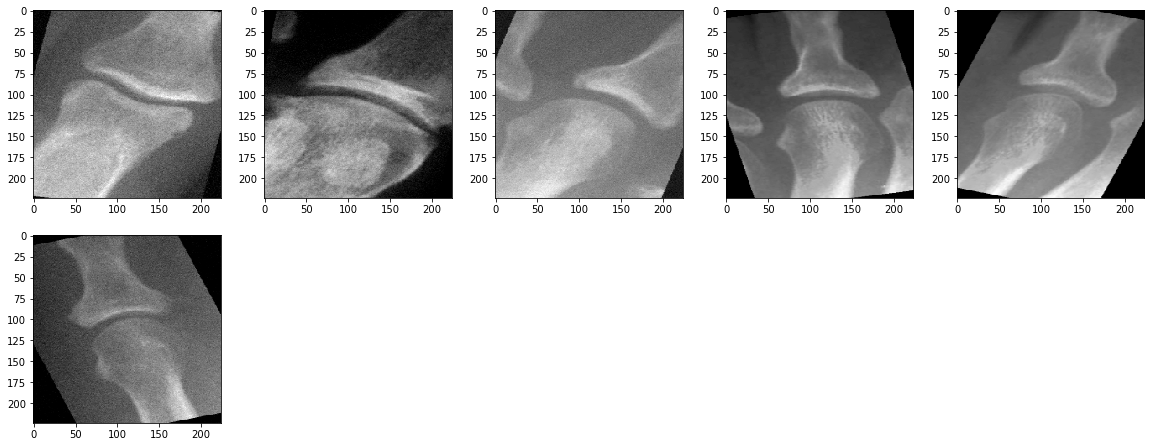

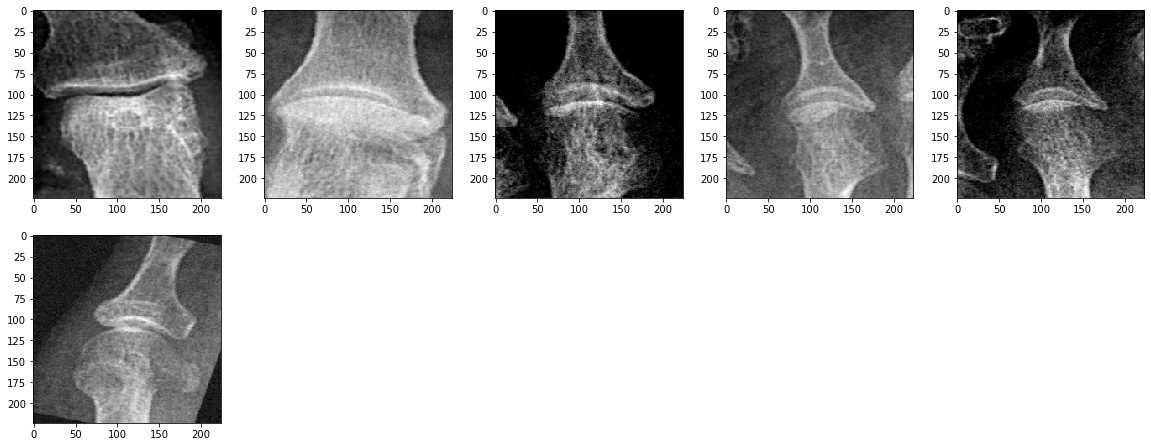

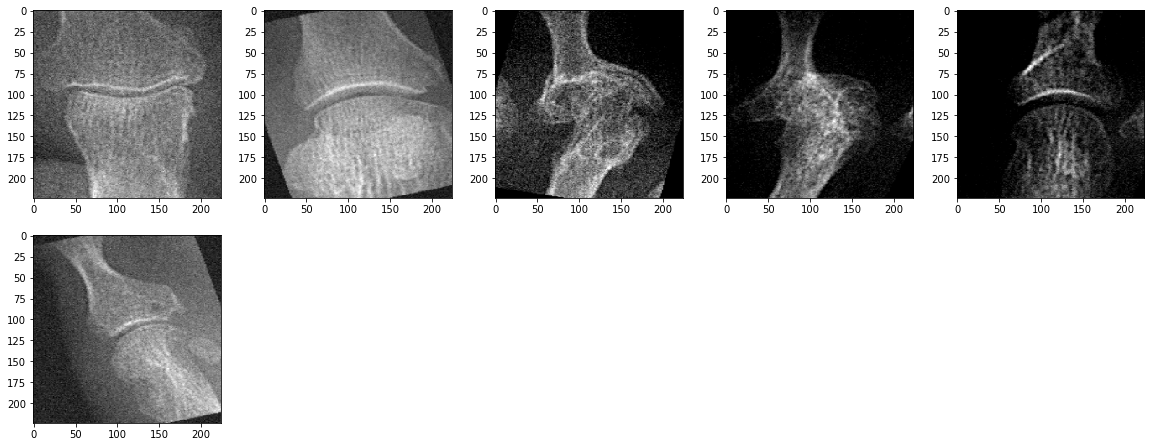

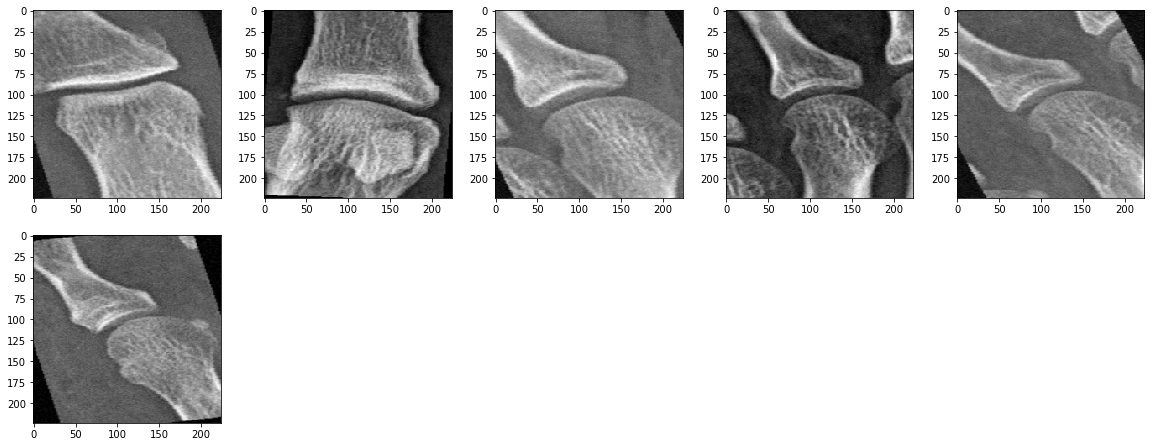

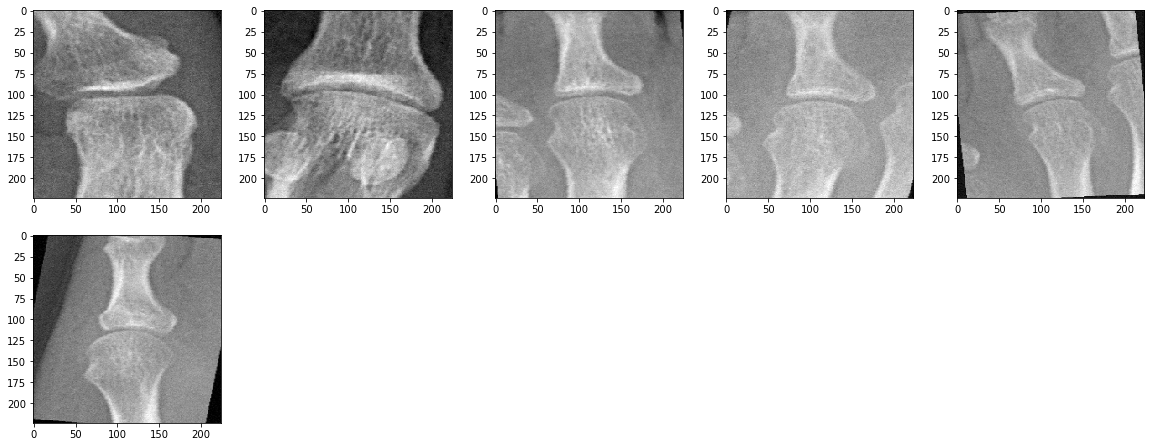

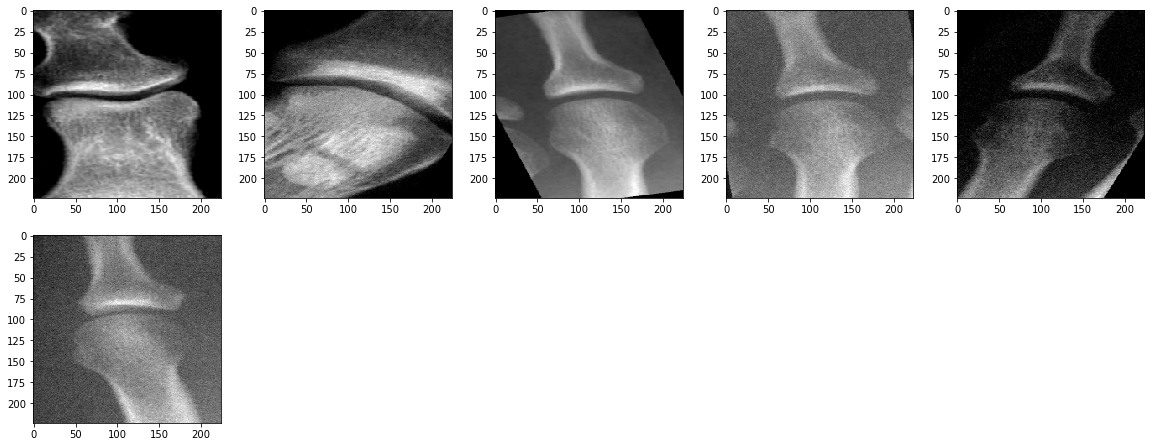

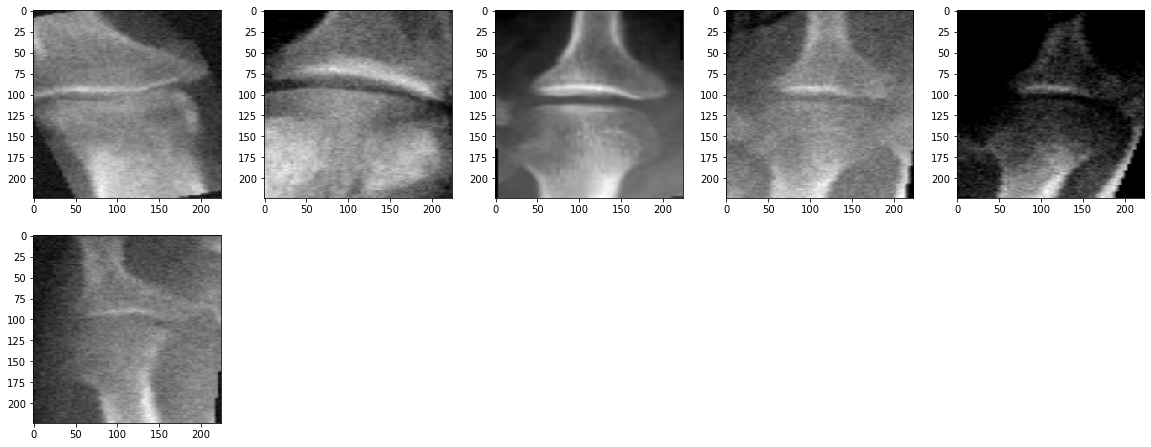

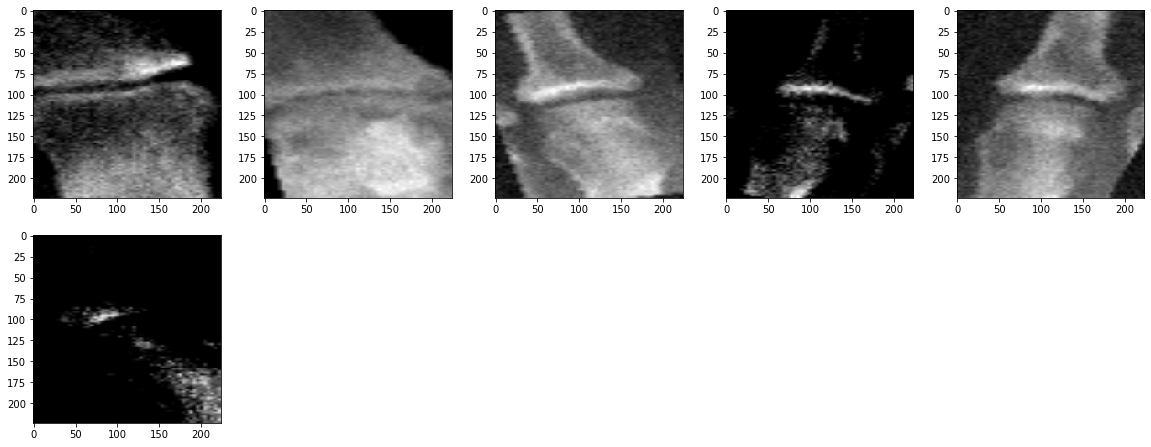

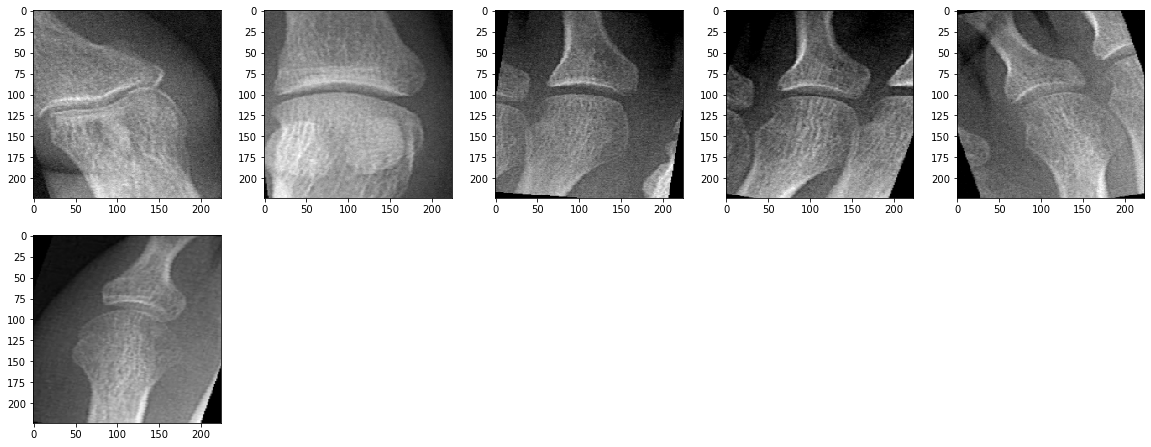

In [22]:
for pat in range(10):
    plt.figure(figsize=(20,20))
    print(da[1][pat])
    for n in range(6):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(da[0][n][pat][:,:,0],cmap="gray")